# Tutorial 1: GLMs for Encoding

**Week 1, Day 3: Generalized Linear Models**

**By Neuromatch Academy**

**Content creators:** Pierre-Etienne H. Fiquet, Ari Benjamin, Jakob Macke

**Content reviewers:** Davide Valeriani, Alish Dipani, Michael Waskom, Ella Batty

**Production editors:** Spiros Chavlis

---
# Tutorial Objectives

*Estimated timing of tutorial: 1 hour, 15 minutes*

This is part 1 of a 2-part series about Generalized Linear Models (GLMs), which are a fundamental framework for supervised learning.

In this tutorial, the objective is to model a retinal ganglion cell spike train by fitting a temporal receptive field. First with a Linear-Gaussian GLM (also known as ordinary least-squares regression model) and then with a Poisson GLM (aka "Linear-Nonlinear-Poisson" model). In the next tutorial, we'll extend to a special case of GLMs, logistic regression, and learn how to ensure good model performance.

This tutorial is designed to run with retinal ganglion cell spike train data from [Uzzell & Chichilnisky 2004](https://journals.physiology.org/doi/full/10.1152/jn.01171.2003?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed).

*Acknowledgements:*

- We thank EJ Chichilnisky for providing the dataset. Please note that it is provided for tutorial purposes only, and should not be distributed or used for publication without express permission from the author (ej@stanford.edu).
- We thank Jonathan Pillow, much of this tutorial is inspired by exercises assigned in his 'Statistical Modeling and Analysis of Neural Data' class.

In [ ]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today
from IPython.display import IFrame
link_id = "upyjz"
print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

If you want to download the slides: https://osf.io/download/upyjz/


---
# Setup

In [ ]:
# @title Install and import feedback gadget

!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_cn",
            "user_key": "y1x3mpx5",
        },
    ).render()


feedback_prefix = "W1D3_T1"

In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.io import loadmat

In [ ]:
# @title Figure settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [ ]:
# @title Plotting Functions

def plot_stim_and_spikes(stim, spikes, dt, nt=120):
  """Show time series of stim intensity and spike counts.

  Args:
    stim (1D array): vector of stimulus intensities
    spikes (1D array): vector of spike counts
    dt (number): duration of each time step
    nt (number): number of time steps to plot

  """
  timepoints = np.arange(nt)
  time = timepoints * dt

  f, (ax_stim, ax_spikes) = plt.subplots(
    nrows=2, sharex=True, figsize=(8, 5),
  )
  ax_stim.plot(time, stim[timepoints])
  ax_stim.set_ylabel('Stimulus intensity')

  ax_spikes.plot(time, spikes[timepoints])
  ax_spikes.set_xlabel('Time (s)')
  ax_spikes.set_ylabel('Number of spikes')

  f.tight_layout()
  plt.show()


def plot_glm_matrices(X, y, nt=50):
  """Show X and Y as heatmaps.

  Args:
    X (2D array): Design matrix.
    y (1D or 2D array): Target vector.

  """
  from matplotlib.colors import BoundaryNorm
  from mpl_toolkits.axes_grid1 import make_axes_locatable
  Y = np.c_[y]  # Ensure Y is 2D and skinny

  f, (ax_x, ax_y) = plt.subplots(
    ncols=2,
    figsize=(6, 8),
    sharey=True,
    gridspec_kw=dict(width_ratios=(5, 1)),
  )
  norm = BoundaryNorm([-1, -.2, .2, 1], 256)
  imx = ax_x.pcolormesh(X[:nt], cmap="coolwarm", norm=norm)

  ax_x.set(
    title="X\n(lagged stimulus)",
    xlabel="Time lag (time bins)",
    xticks=[4, 14, 24],
    xticklabels=['-20', '-10', '0'],
    ylabel="Time point (time bins)",
  )
  plt.setp(ax_x.spines.values(), visible=True)

  divx = make_axes_locatable(ax_x)
  caxx = divx.append_axes("right", size="5%", pad=0.1)
  cbarx = f.colorbar(imx, cax=caxx)
  cbarx.set_ticks([-.6, 0, .6])
  cbarx.set_ticklabels(np.sort(np.unique(X)))

  norm = BoundaryNorm(np.arange(y.max() + 1), 256)
  imy = ax_y.pcolormesh(Y[:nt], cmap="magma", norm=norm)
  ax_y.set(
    title="Y\n(spike count)",
    xticks=[]
  )
  ax_y.invert_yaxis()
  plt.setp(ax_y.spines.values(), visible=True)

  divy = make_axes_locatable(ax_y)
  caxy = divy.append_axes("right", size="30%", pad=0.1)
  cbary = f.colorbar(imy, cax=caxy)
  cbary.set_ticks(np.arange(y.max()) + .5)
  cbary.set_ticklabels(np.arange(y.max()))
  plt.show()


def plot_spike_filter(theta, dt, show=True, **kws):
  """Plot estimated weights based on time lag model.

  Args:
    theta (1D array): Filter weights, not including DC term.
    dt (number): Duration of each time bin.
    kws: Pass additional keyword arguments to plot()
    show (boolean): To plt.show or not the plot.
  """
  d = len(theta)
  t = np.arange(-d + 1, 1) * dt

  ax = plt.gca()
  ax.plot(t, theta, marker="o", **kws)
  ax.axhline(0, color=".2", linestyle="--", zorder=1)
  ax.set(
    xlabel="Time before spike (s)",
    ylabel="Filter weight",
  )
  if show:
    plt.show()


def plot_spikes_with_prediction(spikes, predicted_spikes, dt,
                                nt=50, t0=120, **kws):
  """Plot actual and predicted spike counts.

  Args:
    spikes (1D array): Vector of actual spike counts
    predicted_spikes (1D array): Vector of predicted spike counts
    dt (number): Duration of each time bin.
    nt (number): Number of time bins to plot
    t0 (number): Index of first time bin to plot.
    show (boolean): To plt.show or not the plot.
    kws: Pass additional keyword arguments to plot()

  """
  t = np.arange(t0, t0 + nt) * dt

  f, ax = plt.subplots()
  lines = ax.stem(t, spikes[:nt])
  plt.setp(lines, color=".5")
  lines[-1].set_zorder(1)
  kws.setdefault("linewidth", 3)
  yhat, = ax.plot(t, predicted_spikes[:nt], **kws)
  ax.set(
      xlabel="Time (s)",
      ylabel="Spikes",
  )
  ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
  ax.legend([lines[0], yhat], ["Spikes", "Predicted"])
  plt.show()

In [ ]:
# @title Data retrieval and loading
import os
import hashlib
import requests
from urllib.request import urlretrieve

fname = "RGCdata.mat"
url = "https://osf.io/mzujs/download"
expected_md5 = "1b2977453020bce5319f2608c94d38d0"

if not os.path.isfile(fname):
    try:
        print('Downloading file...')
        urlretrieve(url, fname)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if hashlib.md5(open(fname, 'rb').read()).hexdigest() != expected_md5:
            print("!!! Data download appears corrupted !!!")
        else:
            print('Download successful.')

---
# Section 1: Linear-Gaussian GLM

In [ ]:
# @title Video 1: Linear Gaussian model
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'Yv89UHeSa9I'), ('Bilibili', 'BV17T4y1E75x')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Linear_Gaussian_Model_Video")

## Section 1.1: Load retinal ganglion cell activity data

*Estimated timing to here from start of tutorial: 10 min*

In this exercise we use data from an experiment that presented a screen which randomly alternated between two luminance values and recorded responses from retinal ganglion cell (RGC), a type of neuron in the retina in the back of the eye. This kind of visual stimulus is called a "full-field flicker", and it was presented at ~120Hz (ie. the stimulus presented on the screen was refreshed about every 8ms). These same time bins were used to count the number of spikes emitted by each neuron.

The file `RGCdata.mat` contains three variables:

- `Stim`, the stimulus intensity at each time point. It is an array with shape $T \times 1$, where $T=144051$.

-  `SpCounts`, the binned spike counts for 2 ON cells, and 2 OFF cells. It is a $144051 \times 4$ array, and each column has counts for a different cell.

- `dtStim`, the size of a single time bin (in seconds), which is needed for computing model output in units of spikes / s. The stimulus frame rate is given by `1 / dtStim`.

Because these data were saved in MATLAB, where everything is a matrix, we will also process the variables to more Pythonic representations (1D arrays or scalars, where appropriate) as we load the data.

In [ ]:
# bypass the issue with nma server

!wget https://github.com/pillowlab/neu560data/blob/master/RGCdata.mat?raw=true
!mv RGCdata.mat?raw=true RGCdata.mat



--2025-07-09 07:23:42--  https://github.com/pillowlab/neu560data/blob/master/RGCdata.mat?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/pillowlab/neu560data/raw/refs/heads/master/RGCdata.mat [following]
--2025-07-09 07:23:42--  https://github.com/pillowlab/neu560data/raw/refs/heads/master/RGCdata.mat
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pillowlab/neu560data/refs/heads/master/RGCdata.mat [following]
--2025-07-09 07:23:42--  https://raw.githubusercontent.com/pillowlab/neu560data/refs/heads/master/RGCdata.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected

In [ ]:
data = loadmat('RGCdata.mat')  # loadmat is a function in scipy.io
dt_stim = data['dtStim'].item()  # .item extracts a scalar value

# Extract the stimulus intensity
stim = data['Stim'].squeeze()  # .squeeze removes dimensions with 1 element

# Extract the spike counts for one cell
cellnum = 2 # use cell number 2
spikes = data['SpCounts'][:, cellnum]

# Don't use all of the timepoints in the dataset, for speed
keep_timepoints = 20000
stim = stim[:keep_timepoints]
spikes = spikes[:keep_timepoints]

print(data['Stim'].shape)
print(data['SpCounts'].shape)

(144051, 1)
(144051, 4)


In [ ]:
help(plot_stim_and_spikes)

Help on function plot_stim_and_spikes in module __main__:

plot_stim_and_spikes(stim, spikes, dt, nt=120)
    Show time series of stim intensity and spike counts.
    
    Args:
      stim (1D array): vector of stimulus intensities
      spikes (1D array): vector of spike counts
      dt (number): duration of each time step
      nt (number): number of time steps to plot



Use the `plot_stim_and_spikes` helper function to visualize the changes in stimulus intensities and spike counts over time.

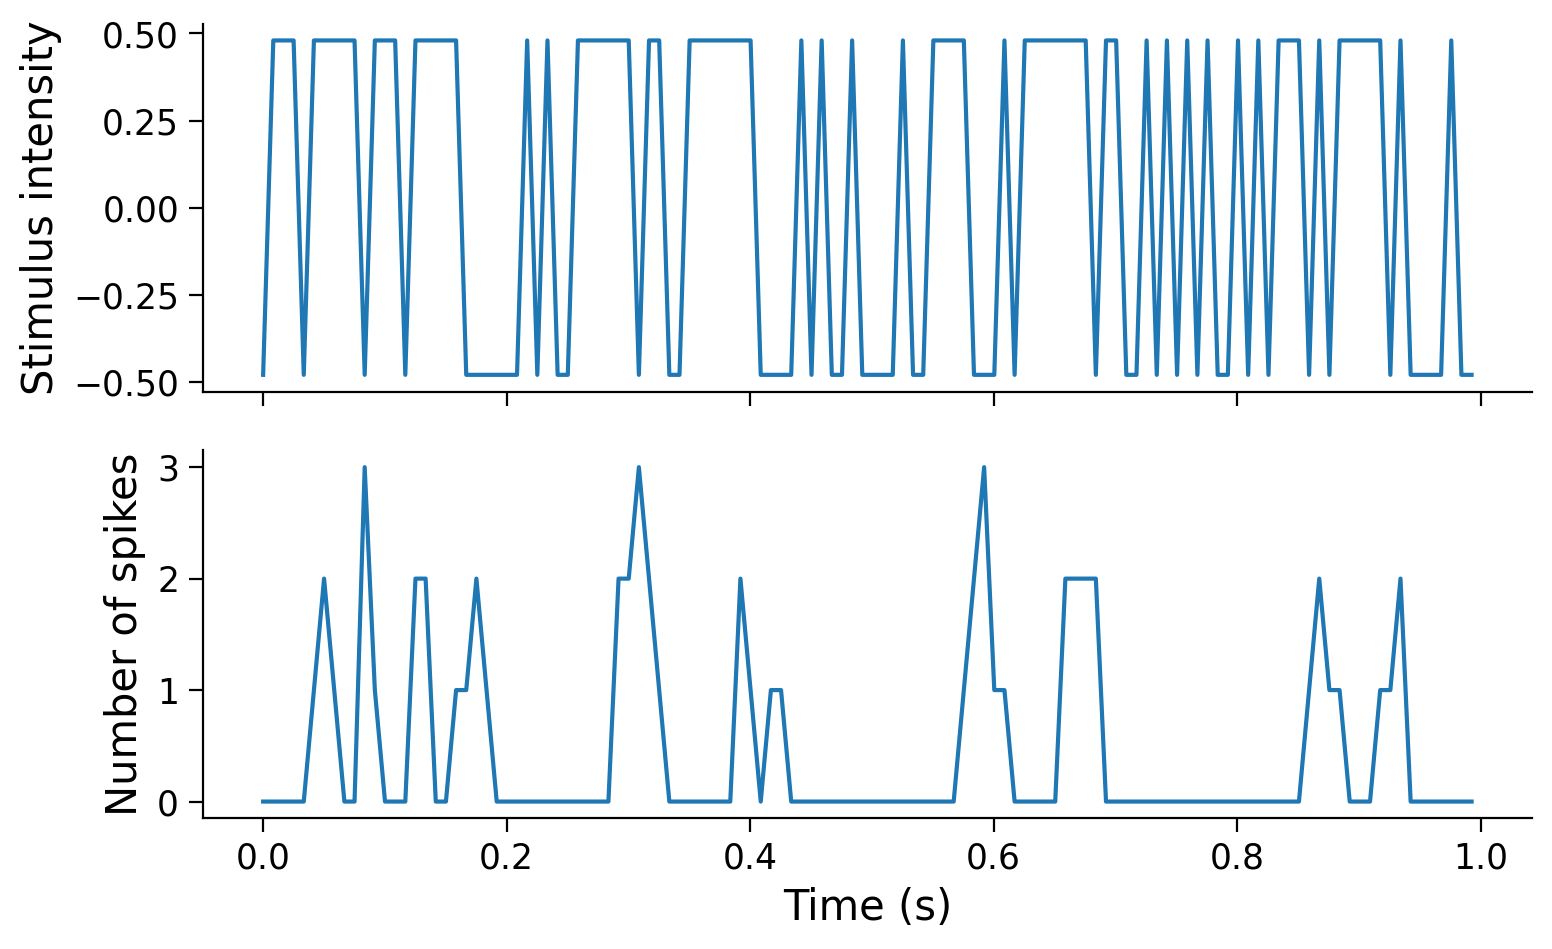

In [ ]:
plot_stim_and_spikes(stim, spikes, dt_stim)

### Coding Exercise 1.1: Create design matrix

Our goal is to predict the cell's activity from the stimulus intensities preceding it. That will help us understand how RGCs process information over time. To do so, we first need to create the *design matrix* for this model, which organizes the stimulus intensities in matrix form such that the $i$th row has the stimulus frames preceding timepoint $i$.

In this exercise, we will create the design matrix $\mathbf{X}$ using $d=25$ time lags. That is, $\mathbf{X}$ should be a $T \times d$ matrix. $d = 25$ (about 200 ms) is a choice we're making based on our prior knowledge of the temporal window that influences RGC responses. In practice, you might not know the right duration to use.

The last entry in row `t` should correspond to the stimulus that was shown at time `t`, the entry to the left of it should contain the value that was shown one time bin earlier, etc. Specifically, $X_{ij}$ will be the stimulus intensity at time $i + d - 1 - j$.

Note that for the first few time bins, we have access to the recorded spike counts but not to the stimulus shown in the recent past. For simplicity we are going to assume that values of `stim` are 0 for the time lags prior to the first timepoint in the dataset. This is known as "zero-padding", so that the design matrix has the same number of rows as the response vectors in `spikes`.

Your task is is to complete the function below to:

  - make a zero-padded version of the stimulus
  - initialize an empty design matrix with the correct shape
  - **fill in each row of the design matrix, using the zero-padded version of the stimulus**

To visualize your design matrix (and the corresponding vector of spike counts), we will plot a "heatmap", which encodes the numerical value in each position of the matrix as a color. The helper functions include some code to do this.

(20000, 25) 0.48 -0.48 -7.295999999999891e-05


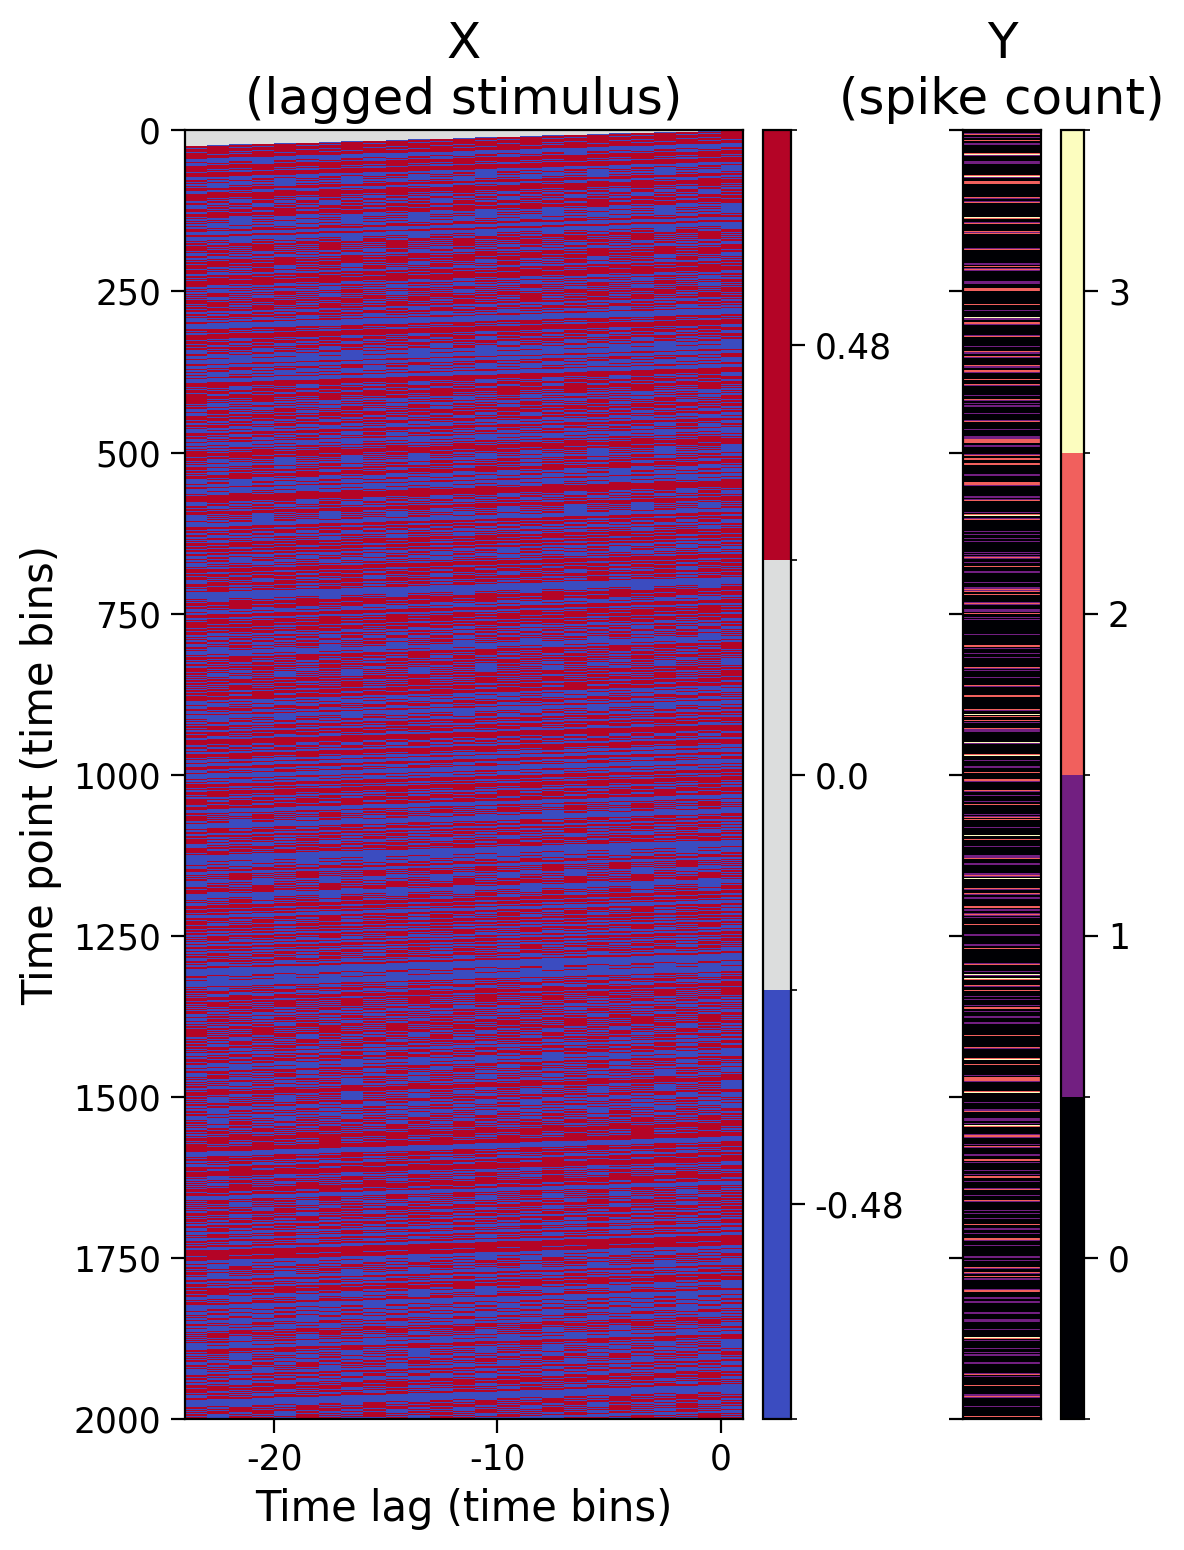

In [ ]:
def make_design_matrix(stim, d=25):
  """Create time-lag design matrix from stimulus intensity vector.

  Args:
    stim (1D array): Stimulus intensity at each time point.
    d (number): Number of time lags to use.

  Returns
    X (2D array): GLM design matrix with shape T, d

  """

  # Create version of stimulus vector with zeros before onset
  padded_stim = np.concatenate([np.zeros(d - 1), stim])

  #####################################################################
  # Fill in missing code (...),
  # then remove or comment the line below to test your function
  # print("Complete the make_design_matrix function")
  #####################################################################


  # Construct a matrix where each row has the d frames of
  # the stimulus preceding and including timepoint t
  T = len(stim)  # Total number of timepoints (hint: number of stimulus frames)
  X = np.zeros((T, d))
  for t in range(T):
      X[t] = padded_stim[t:t + d]


  return X


# Make design matrix
X = make_design_matrix(stim)
print(X.shape, np.max(X), np.min(X), np.mean(X))
# Visualize
plot_glm_matrices(X, spikes, nt= 20_00)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W1D3_GeneralizedLinearModels/solutions/W1D3_Tutorial1_Solution_03ed3adf.py)

*Example output:*

<img alt='Solution hint' align='left' width=584.0 height=778.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W1D3_GeneralizedLinearModels/static/W1D3_Tutorial1_Solution_03ed3adf_0.png>



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Create_design_matrix_Exercise")

## Section 1.2: Fit Linear-Gaussian regression model

*Estimated timing to here from start of tutorial: 25 min*


First, we will use the design matrix to compute the maximum likelihood estimate for a linear-Gaussian GLM (aka "general linear model"). The maximum likelihood estimate of $\theta$ in this model can be solved analytically using the equation you learned about on Day 3:

\begin{equation}
\boldsymbol{\hat \theta} = (\mathbf{X}^{\top}\mathbf{X})^{-1}\mathbf{X}^{\top}\mathbf{y}
\end{equation}

Before we can apply this equation, we need to augment the design matrix to account for the mean of $y$, because the spike counts are all $\geq 0$. We do this by adding a constant column of 1's to the design matrix, which will allow the model to learn an additive offset weight. We will refer to this additional weight as $b$ (for bias), although it is alternatively known as a "DC term" or "intercept".

In [ ]:
# Build the full design matrix
y = spikes
constant = np.ones_like(y)
X = np.column_stack([constant, make_design_matrix(stim)])

# Get the MLE weights for the LG model
theta = np.linalg.inv(X.T @ X) @ X.T @ y
theta_lg = theta[1:]

print(X.shape, np.max(X), np.min(X), np.mean(X))
print(theta.shape, np.max(theta), np.min(theta), np.mean(theta))
print(theta_lg.shape, np.max(theta_lg), np.min(theta_lg), np.mean(theta_lg), '\n')
print(y.shape)

print('\n')
print((X.T @ X).shape, X.T.shape, (X.T @ y).shape)

print(theta)

(20000, 26) 1.0 -0.48 0.038391384615384605
(26,) 0.5755605709186993 -0.21251581685578666 0.014109129986956424
(25,) 0.5755605709186993 -0.21251581685578666 0.0004904091937909915 

(20000,)


(26, 26) (26, 20000) (26,)
[ 3.54577150e-01 -1.30069004e-02  3.41569302e-04  6.73822770e-03
  7.23694327e-03 -6.29805903e-04  1.77192831e-03 -5.33178172e-03
 -3.17713423e-02 -4.35242744e-02 -6.52148150e-02 -8.71033465e-02
 -8.81600231e-02 -1.39915563e-01 -1.51425398e-01 -1.65489263e-01
 -1.55096415e-01 -1.76273624e-01 -2.12515817e-01 -1.39405807e-01
  3.03378200e-01  5.75560571e-01  4.40597192e-01  1.37118832e-01
  1.60489968e-02 -1.66805519e-03]


In [ ]:
help(plot_spike_filter)

Help on function plot_spike_filter in module __main__:

plot_spike_filter(theta, dt, show=True, **kws)
    Plot estimated weights based on time lag model.
    
    Args:
      theta (1D array): Filter weights, not including DC term.
      dt (number): Duration of each time bin.
      kws: Pass additional keyword arguments to plot()
      show (boolean): To plt.show or not the plot.



Plot the resulting maximum likelihood filter estimate (just the 25-element weight vector $\theta$ on the stimulus elements, not the DC term $b$).

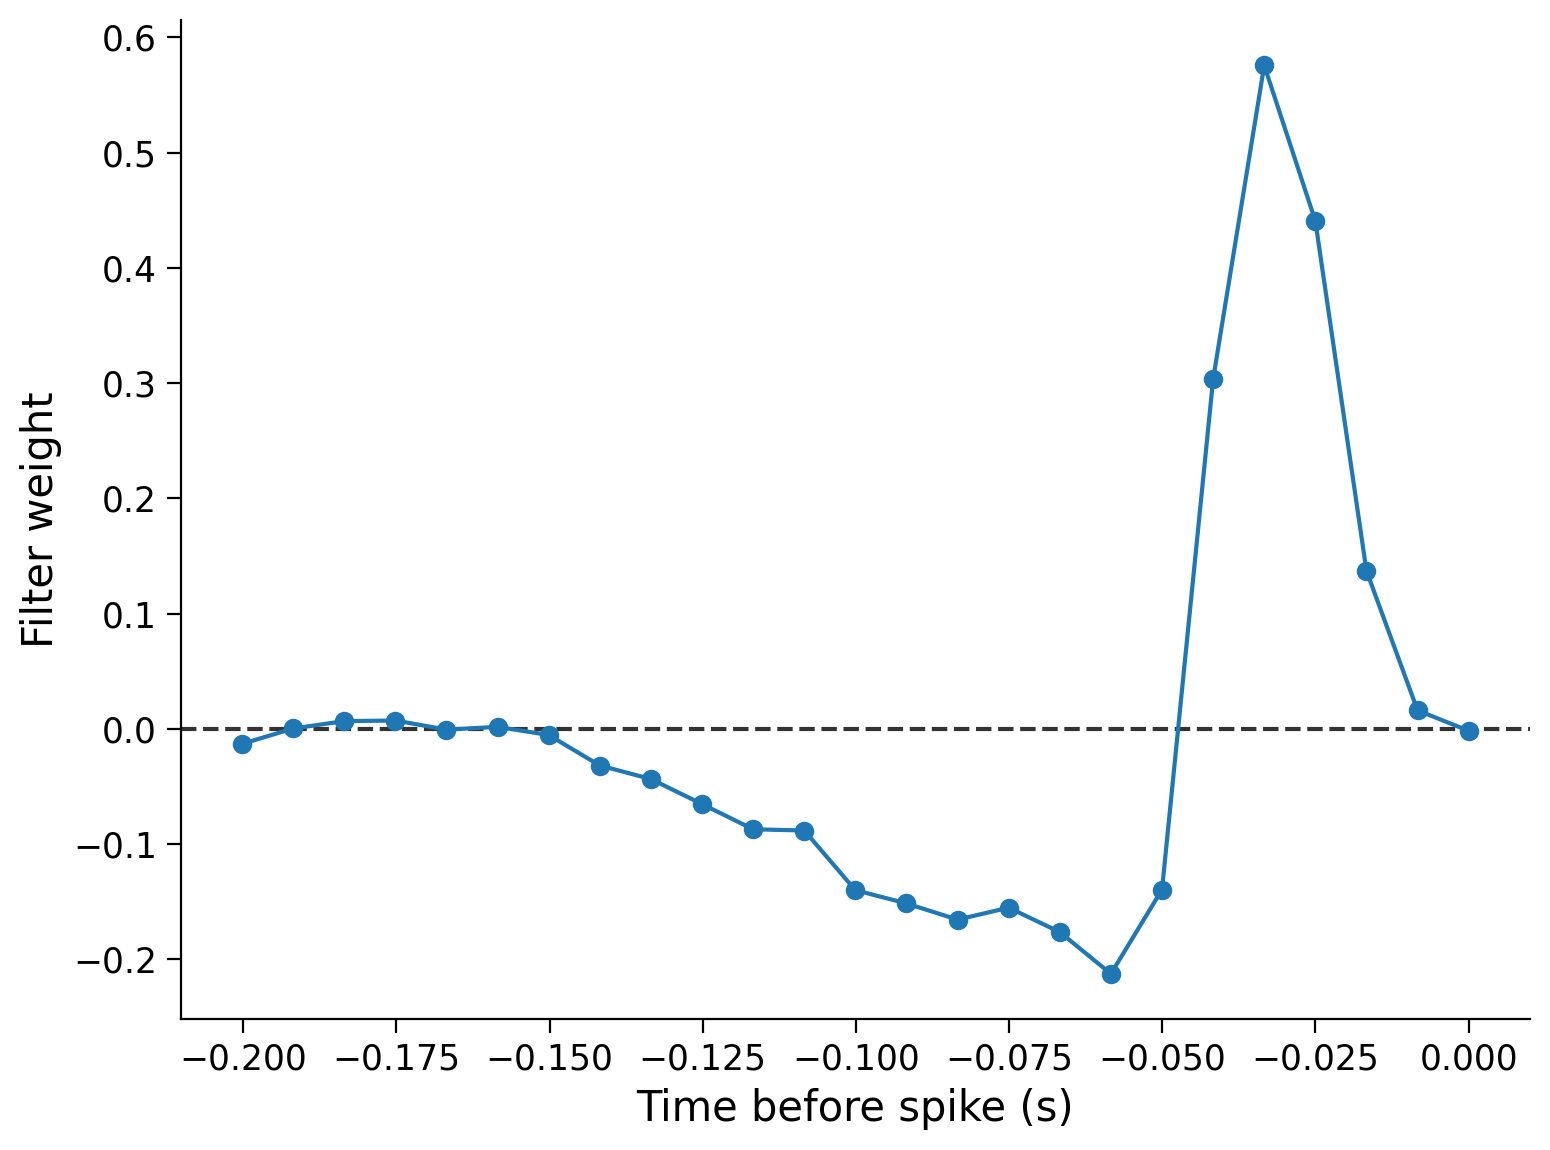

In [ ]:
plot_spike_filter(theta_lg, dt_stim)

### Coding Exercise 1.2: Predict spike counts with Linear-Gaussian model

Now we are going to put these pieces together and write a function that outputs a predicted spike count for each timepoint using the stimulus information.

Your steps should be:

- Create the complete design matrix
- Obtain the MLE weights ($\boldsymbol{\hat \theta}$)
- Compute $\mathbf{\hat y} = \mathbf{X}\boldsymbol{\hat \theta}$

(20000,) 1.73888371469379 0.35465


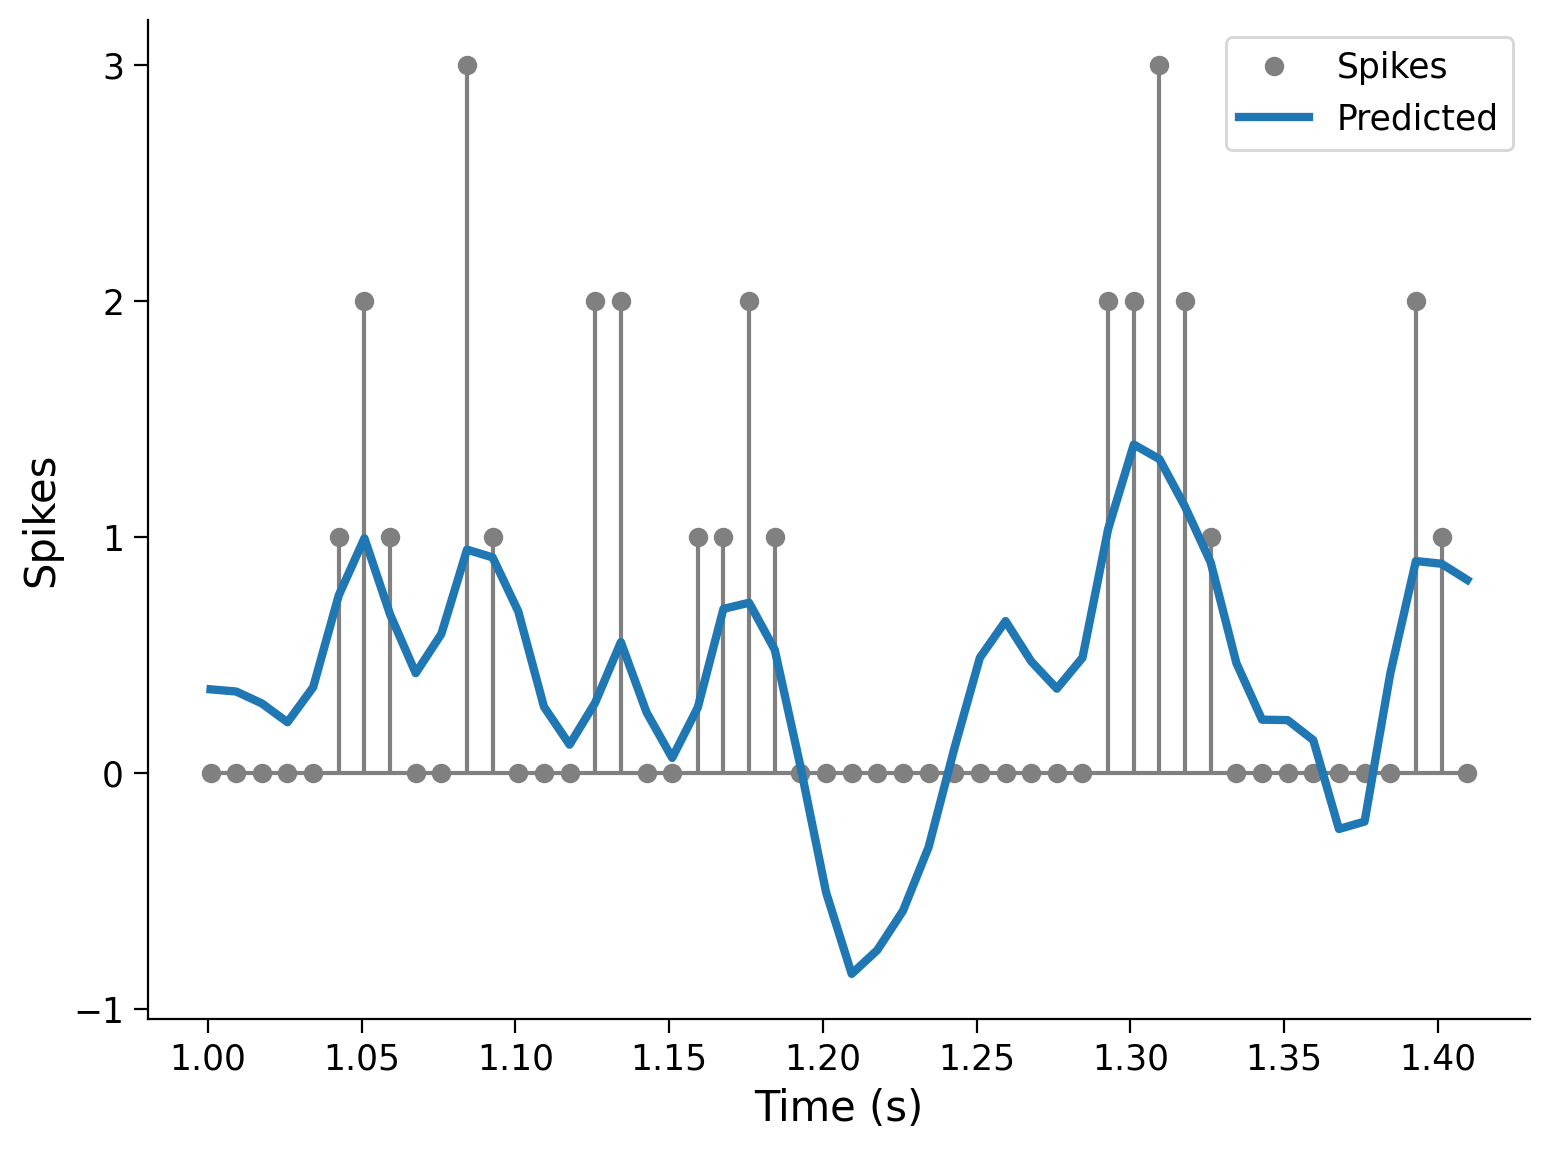

In [ ]:
def predict_spike_counts_lg(stim, spikes, d=25):
  """Compute a vector of predicted spike counts given the stimulus.

  Args:
    stim (1D array): Stimulus values at each timepoint
    spikes (1D array): Spike counts measured at each timepoint
    d (number): Number of time lags to use.

  Returns:
    yhat (1D array): Predicted spikes at each timepoint.

  """
  ##########################################################################
  # Fill in missing code (...) and then comment or remove the error to test
  # print("Complete the predict_spike_counts_lg function")
  ##########################################################################

  # Create the design matrix
  y = spikes
  constant = np.ones_like(y) # DC offset term

  X = np.column_stack([constant, make_design_matrix(stim)]) # augment design matrix to account for the dc term

  # Get the MLE weights for the LG model
  theta = np.linalg.inv(X.T @ X) @ X.T @ y # standard sol

  # Compute predicted spike counts
  yhat = X @ theta

  return yhat


# Predict spike counts
predicted_counts = predict_spike_counts_lg(stim, spikes)
print(predicted_counts.shape, np.max(predicted_counts), np.mean(predicted_counts))

# Visualize
plot_spikes_with_prediction(spikes, predicted_counts, dt_stim)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W1D3_GeneralizedLinearModels/solutions/W1D3_Tutorial1_Solution_823fa455.py)

*Example output:*

<img alt='Solution hint' align='left' width=777.0 height=577.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W1D3_GeneralizedLinearModels/static/W1D3_Tutorial1_Solution_823fa455_0.png>



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Predict_counts_with_Linear_Gaussian_model_Exercise")

Is this a good model? The prediction line more-or-less follows the bumps in the spikes, but it never predicts as many spikes as are actually observed. And, more troublingly, it's predicting *negative* spikes for some time points.

The Poisson GLM will help to address these failures.


### Bonus challenge

The "spike-triggered average" falls out as a subcase of the linear Gaussian GLM: $\mathrm{STA} = \mathbf{X}^{\top} \mathbf{y} \,/\, \textrm{sum}(\mathbf{y})$, where $\mathbf{y}$ is the vector of spike counts of the neuron. In the LG GLM, the term $(\mathbf{X}^{\top}\mathbf{X})^{-1}$ corrects for potential correlation between the regressors. Because the experiment that produced these data used a white noise stimulus, there are no such correlations. Therefore the two methods are equivalent. (How would you check the statement about no correlations?)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Bonus_Challenge_Activity")

---
# Section 2: Linear-Nonlinear-Poisson GLM

*Estimated timing to here from start of tutorial: 36 min*


In [ ]:
# @title Video 2: Generalized linear model
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'wRbvwdze4uE'), ('Bilibili', 'BV1mz4y1X7JZ')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Generalized_linear_model_Video")

## Section 2.1: Nonlinear optimization with `scipy.optimize`

*Estimated timing to here from start of tutorial: 45 min*

Before diving into the Poisson GLM case, let us review the use and importance of convexity in optimization:
- We have seen previously that in the Linear-Gaussian case, maximum likelihood  parameter estimate can be computed analytically. That is great because it only takes us a single line of code!
- Unfortunately in general there is no analytical solution to our statistical estimation problems of interest. Instead, we need to apply a nonlinear optimization algorithm to find the parameter values that minimize some *objective function*. This can be extremely tedious because there is no general way to check whether we have found *the optimal solution* or if we are just stuck in some local minimum.
- Somewhere in between these two extremes, the special case of convex objective function is of great practical importance. Indeed, such optimization problems can be solved very reliably (and usually quite rapidly too!) using some standard software.

Notes:
- a function is convex if and only if its curve lies below any chord joining two of its points
- to learn more about optimization, you can consult the book of Stephen Boyd and Lieven Vandenberghe [Convex Optimization](https://web.stanford.edu/~boyd/cvxbook/).

Here we will use the `scipy.optimize` module, it contains a function called [`minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) that provides a generic interface to a large number of optimization algorithms. This function expects as argument an objective function and an "initial guess" for the parameter values. It then returns a dictionary that includes the minimum function value, the parameters that give this minimum, and other information.

Let's see how this works with a simple example. We want to minimize the function $f(x) = x^2$:

In [ ]:
f = np.square
res = minimize(f, x0=2)
print(f"Minimum value: {res['fun']:.4g} at x = {res['x'].item():.5e}")
# help(minimize)

# minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
#     Minimization of scalar function of one or more variables.
# help(minimize)


Minimum value: 3.566e-16 at x = -1.88846e-08


When minimizing a $f(x) = x^2$, we get a minimum value of $f(x) \approx 0$ when $x \approx 0$. The algorithm doesn't return exactly $0$, because it stops when it gets "close enough" to a minimum. You can change the `tol` parameter to control how it defines "close enough".

A point about the code bears emphasis. The first argument to `minimize` is not a number or a string but a *function*. Here, we used `np.square`. Take a moment to make sure you understand what's going on, because it's a bit unusual, and it will be important for the exercise you're going to do in a moment.

In this example, we started at $x_0 = 2$. Let's try different values for the starting point:

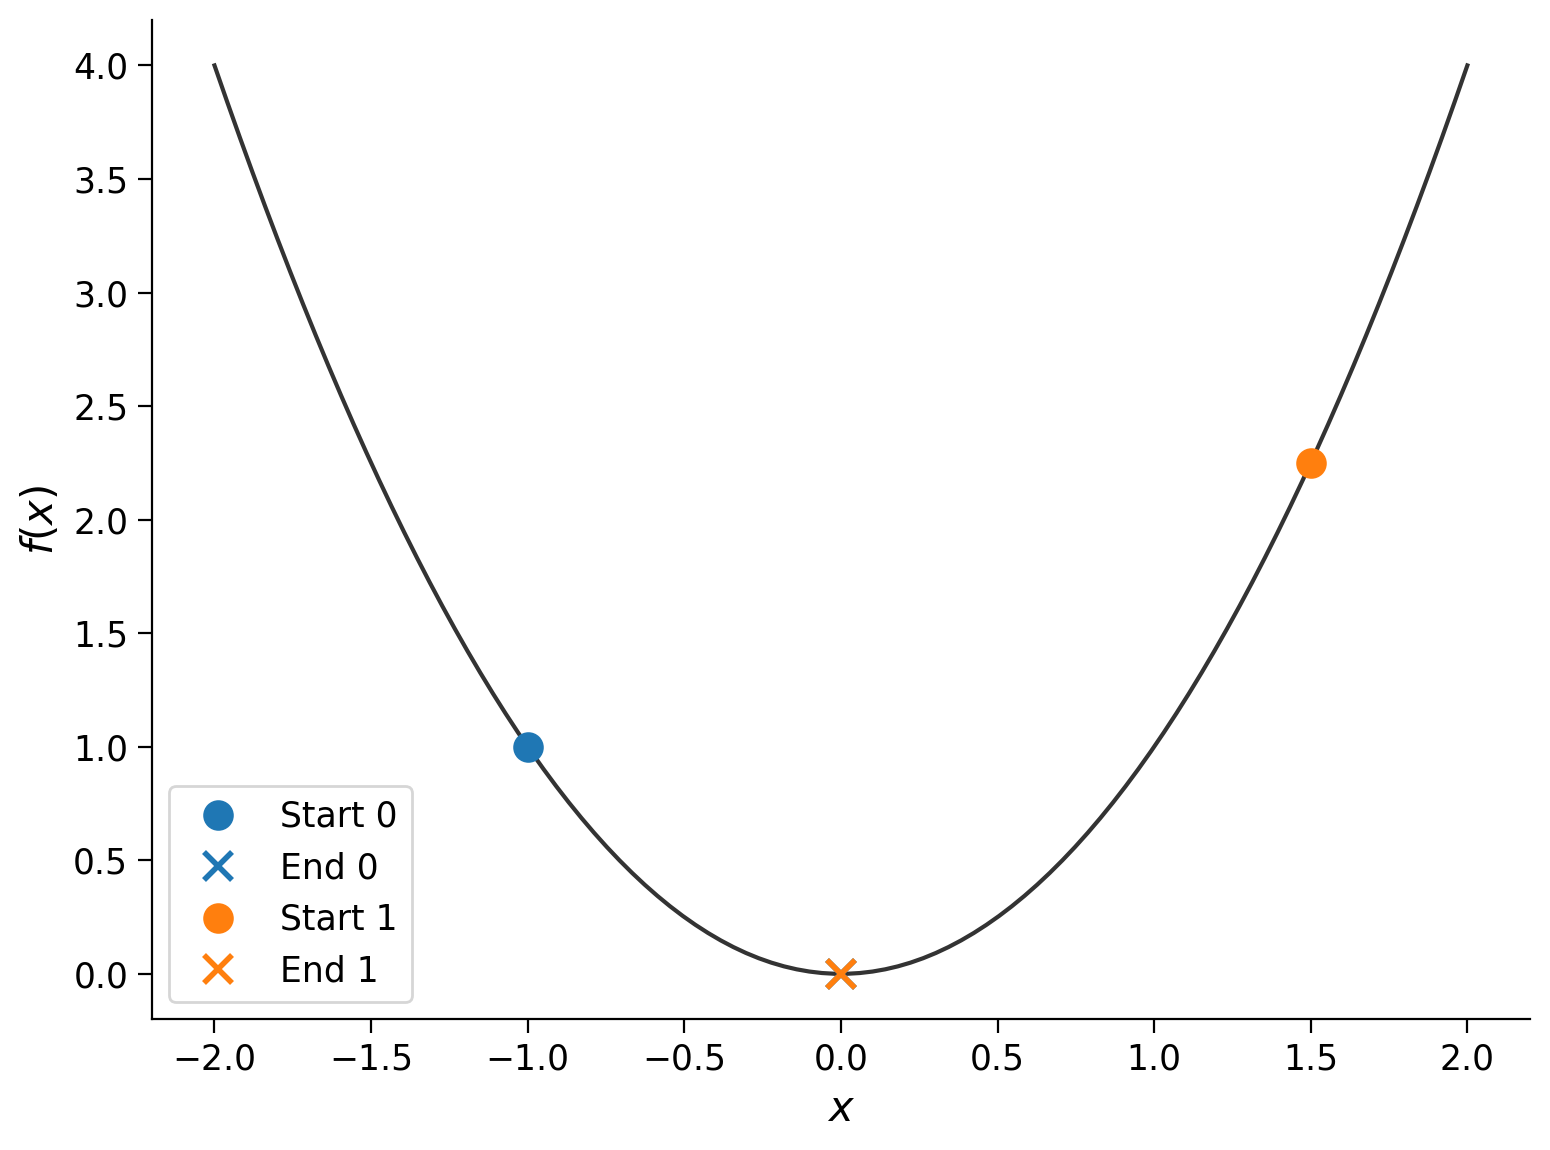

In [ ]:
start_points = -1, 1.5

xx = np.linspace(-2, 2, 100)
plt.plot(xx, f(xx), color=".2")
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

for i, x0 in enumerate(start_points):
  res = minimize(f, x0)
  plt.plot(x0, f(x0), "o", color=f"C{i}", ms=10, label=f"Start {i}")
  plt.plot(res["x"].item(), res["fun"], "x", c=f"C{i}",
           ms=10, mew=2, label=f"End {i}")
plt.legend()
plt.show()

The runs started at different points (the dots), but they each ended up at roughly the same place (the cross): $f(x_\textrm{final}) \approx 0$. Let's see what happens if we use a different function:

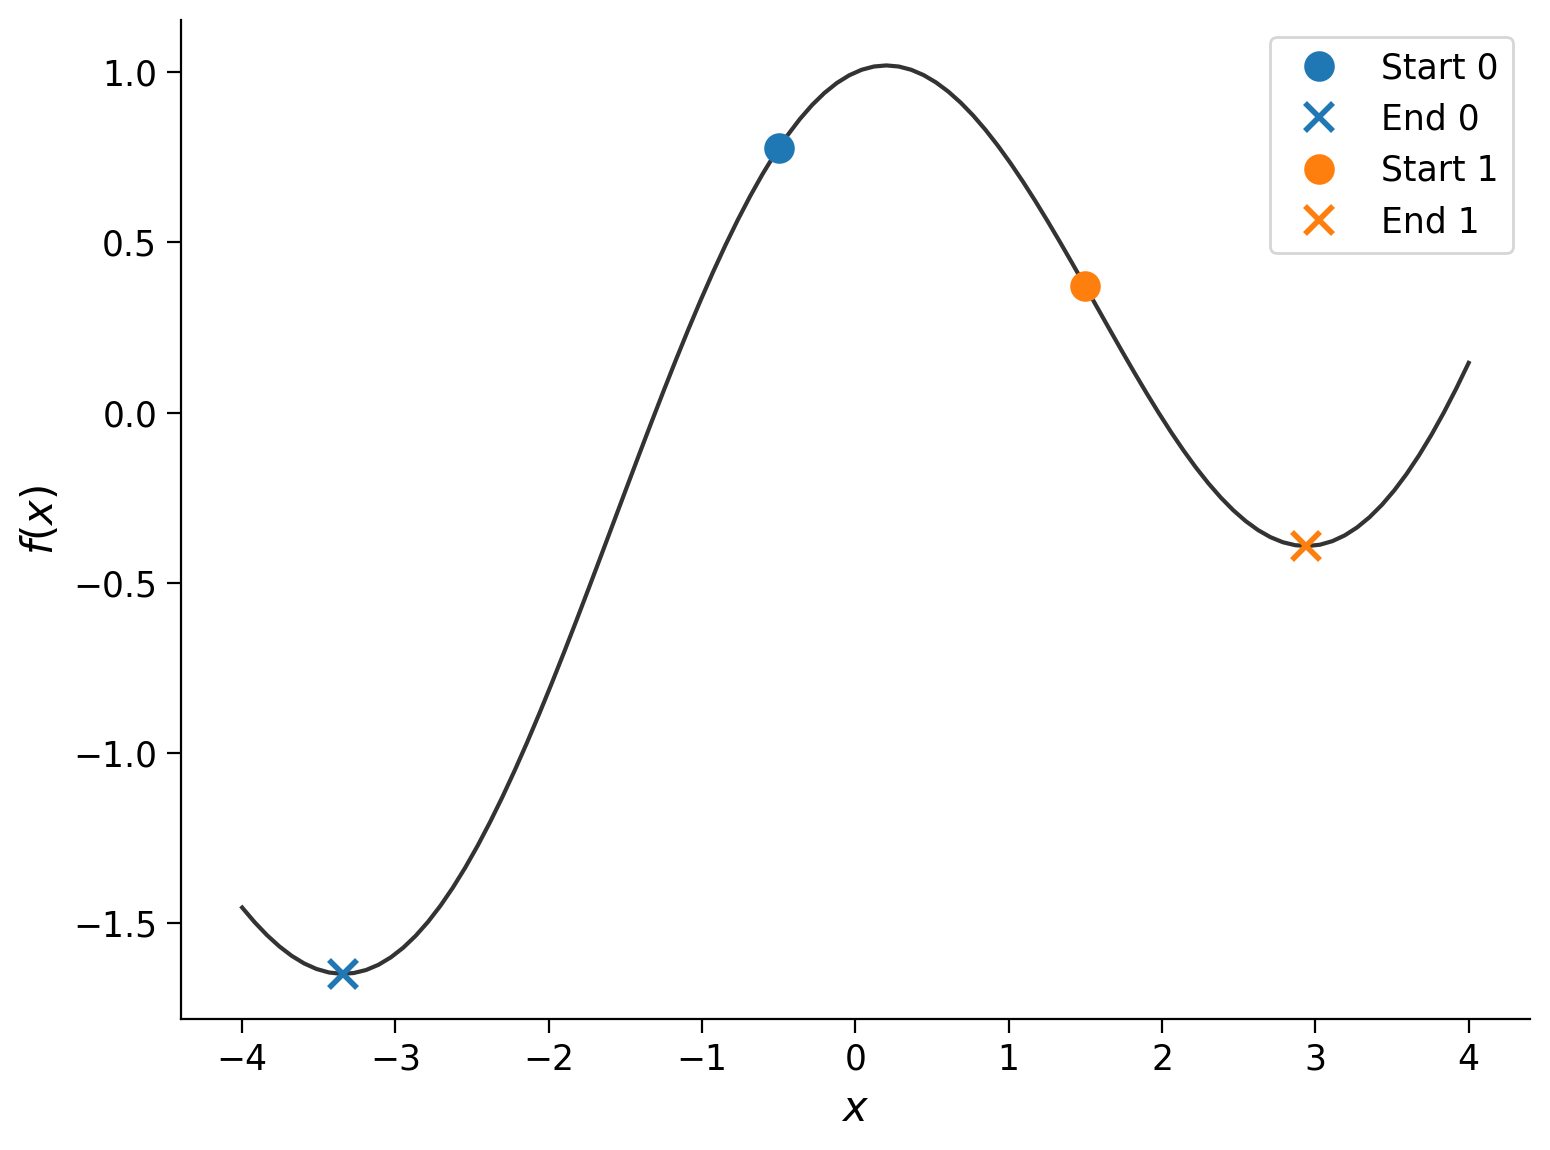

In [ ]:
g = lambda x: x / 5 + np.cos(x)
start_points = -.5, 1.5

xx = np.linspace(-4, 4, 100)
plt.plot(xx, g(xx), color=".2")
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

for i, x0 in enumerate(start_points):
  res = minimize(g, x0)
  plt.plot(x0, g(x0), "o", color=f"C{i}", ms=10, label=f"Start {i}")
  plt.plot(res["x"].item(), res["fun"], "x", color=f"C{i}",
           ms=10, mew=2, label=f"End {i}")
plt.legend()
plt.show()

Unlike $f(x) = x^2$, $g(x) = \frac{x}{5} + \cos(x)$ is not *convex*. We see that the final position of the minimization algorithm depends on the starting point, which adds a layer of complexity to such problems.

### Coding Exercise 2.1: Fitting the Poisson GLM and prediction spikes

In this exercise, we will use [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) to compute maximum likelihood estimates for the filter weights in the Poisson GLM model with an exponential nonlinearity (LNP: Linear-Nonlinear-Poisson).

In practice, this will involve filling out two functions.

- The first should be an *objective function* that takes a design matrix, a spike count vector, and a vector of parameters. It should return a negative log likelihood.
- The second function should take `stim` and `spikes`, build the design matrix and then use `minimize` internally, and return the MLE parameters.

What should the objective function look like? We want it to return the negative log likelihood: $-\log P(y \mid \mathbf{X}, \theta).$

In the Poisson GLM,

\begin{equation}
\log P(\mathbf{y} \mid \mathbf{X}, \theta) = \sum_t \log P(y_t \mid \mathbf{x_t},\theta),
\end{equation}

where

\begin{equation}
P(y_t \mid \mathbf{x_t}, \theta) = \frac{\lambda_t^{y_t}\exp(-\lambda_t)}{y_t!} \text{, with rate } \lambda_t = \exp(\mathbf{x_t}^{\top} \theta).
\end{equation}

Now, taking the log likelihood for all the data we obtain:

\begin{equation}
\log P(\mathbf{y} \mid X, \theta) = \sum_t( y_t \log\left(\lambda_t) - \lambda_t - \log(y_t !)\right).
\end{equation}

Because we are going to minimize the negative log likelihood with respect to the parameters $\theta$, we can ignore the last term that does not depend on $\theta$. For faster implementation, let us rewrite this in matrix notation:

\begin{equation}
\mathbf{y}^{\top} \log(\mathbf{\lambda}) - \mathbf{1}^{\top} \mathbf{\lambda} \text{, with  rate } \mathbf{\lambda} = \exp(\mathbf{X} \theta)
\end{equation}

Finally, don't forget to add the minus sign for your function to return the negative log likelihood.

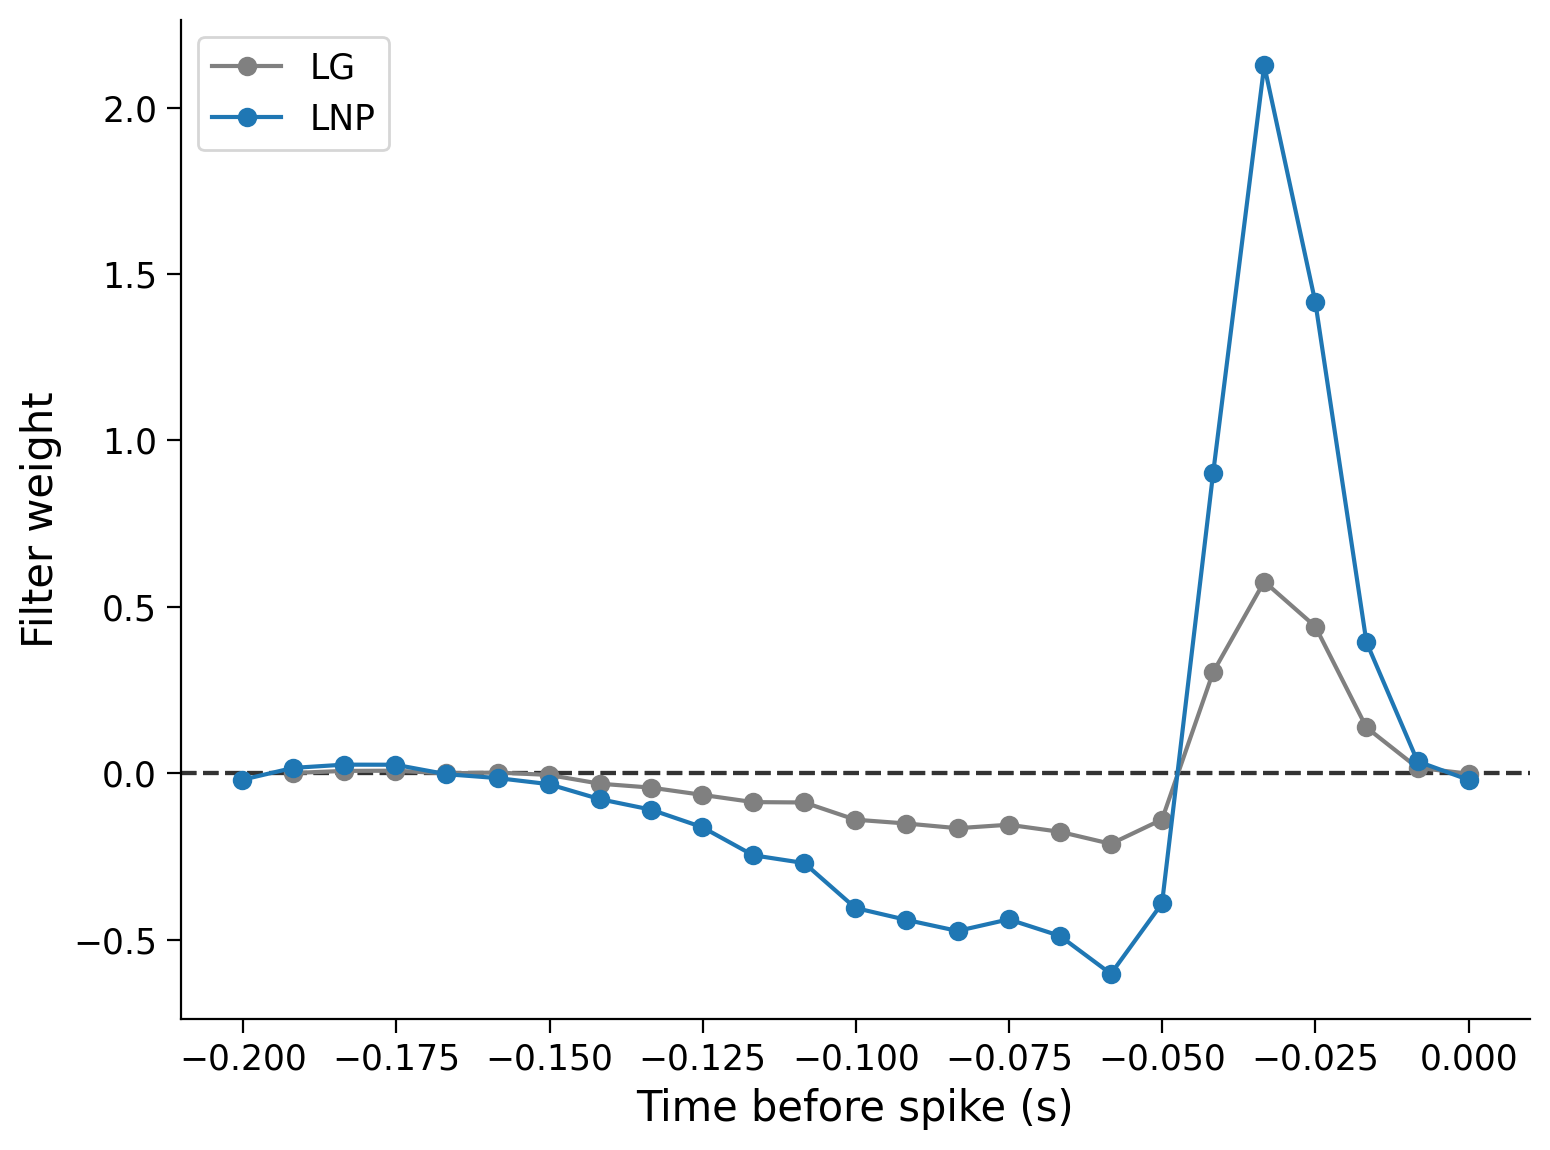

In [ ]:
def neg_log_lik_lnp(theta, X, y):
  """Return -loglike for the Poisson GLM model.

  Args:
    theta (1D array): Parameter vector.
    X (2D array): Full design matrix.
    y (1D array): Data values.

  Returns:
    number: Negative log likelihood.

  """
  #####################################################################
  # Fill in missing code (...), then remove the error
  # print("Complete the neg_log_lik_lnp function")
  #####################################################################

  # Compute the Poisson log likelihood
  rate = np.exp(X @ theta) # predicted spike rate; put linear prediction into exponent
  log_lik = y @ np.log(rate) - np.sum(rate) # calc log likelyhood using poisson

  # we want to max log likelyhood so flip q for practical reasons

  return -log_lik


def fit_lnp(stim, spikes, d=25):
  """Obtain MLE parameters for the Poisson GLM.

  Args:
    stim (1D array): Stimulus values at each timepoint
    spikes (1D array): Spike counts measured at each timepoint
    d (number): Number of time lags to use.

  Returns:
    1D array: MLE parameters

  """
  #####################################################################
  # Fill in missing code (...), then remove the error
  # print("Complete the fit_lnp function")
  #####################################################################

  # Build the design matrix
  y = spikes
  constant = np.ones_like(y)
  X = np.column_stack([constant, make_design_matrix(stim)])

  # Use a random vector of weights to start optimisation (mean 0, sd .2)
  x0 = np.random.normal(0, .2, d + 1) # vector cause have to start a guess for each of the theta parameters
  # choice of vector is lil tricky if not convex | here can give const also but takes waay longer
  # x0 = np.ones(d+1)

  # Find parameters that minimize the negative log likelihood function
  # pass function, why is x0 an array?
  res = minimize(neg_log_lik_lnp, x0 ,args=(X, y))

  return res['x'] # only want argmin


# Fit LNP model
theta_lnp = fit_lnp(stim, spikes)

# Visualize
plot_spike_filter(theta_lg[1:], dt_stim, show=False, color=".5", label="LG")
plot_spike_filter(theta_lnp[1:], dt_stim, show=False, label="LNP")
plt.legend(loc="upper left")
plt.show()

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W1D3_GeneralizedLinearModels/solutions/W1D3_Tutorial1_Solution_a988a95b.py)

*Example output:*

<img alt='Solution hint' align='left' width=777.0 height=577.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W1D3_GeneralizedLinearModels/static/W1D3_Tutorial1_Solution_a988a95b_0.png>



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Fitting_the_Poisson_GLM_Exercise")

Plotting the LG and LNP weights together, we see that they are broadly similar, but the LNP weights are generally larger. What does that mean for the model's ability to *predict* spikes? To see that, let's finish the exercise by filling out the `predict_spike_counts_lnp` function:

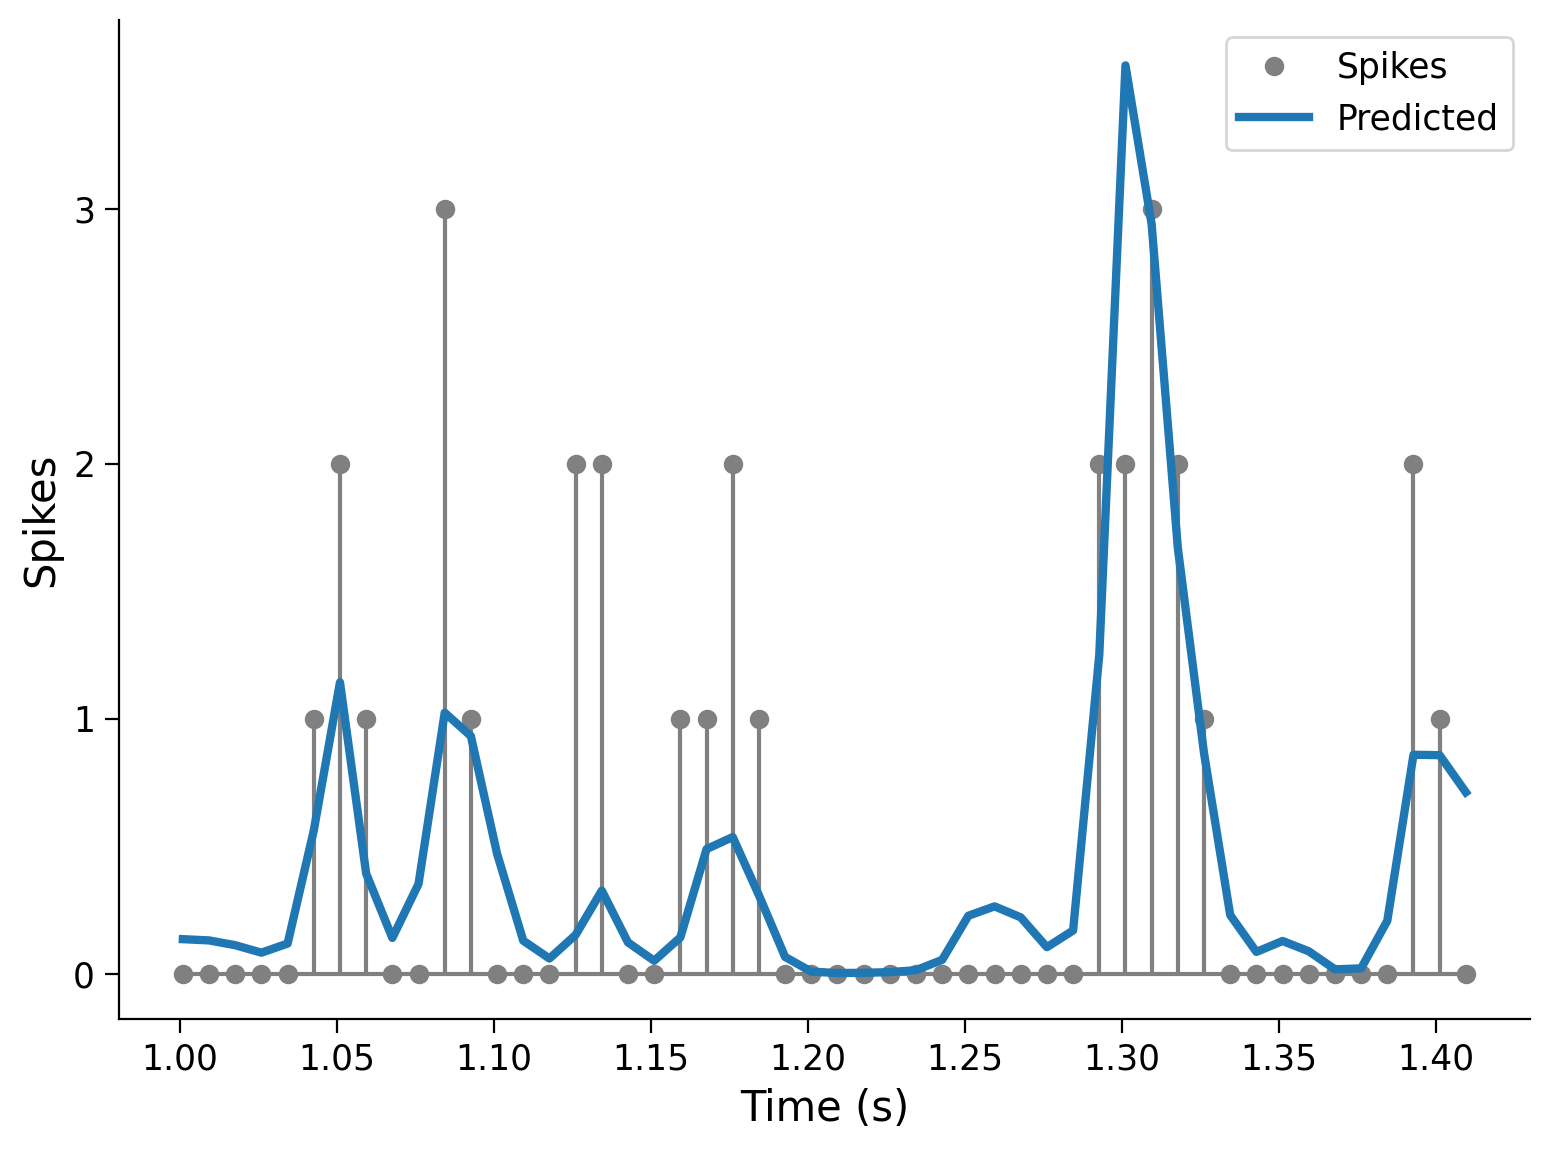

In [ ]:
def predict_spike_counts_lnp(stim, spikes, theta=None, d=25):
  """Compute a vector of predicted spike counts given the stimulus.

  Args:
    stim (1D array): Stimulus values at each timepoint
    spikes (1D array): Spike counts measured at each timepoint
    theta (1D array): Filter weights; estimated if not provided.
    d (number): Number of time lags to use.

  Returns:
    yhat (1D array): Predicted spikes at each timepoint.

  """
  ###########################################################################
  # Fill in missing code (...) and then remove the error to test
  # print("Complete the predict_spike_counts_lnp function")
  ###########################################################################

  y = spikes
  constant = np.ones_like(spikes)
  X = np.column_stack([constant, make_design_matrix(stim)])
  if theta is None:  # Allow pre-cached weights, as fitting is slow
    theta = fit_lnp(X, y, d)

  yhat = np.exp(X @theta)
  return yhat


# Predict spike counts
yhat = predict_spike_counts_lnp(stim, spikes, theta_lnp)

# Visualize
plot_spikes_with_prediction(spikes, yhat, dt_stim)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W1D3_GeneralizedLinearModels/solutions/W1D3_Tutorial1_Solution_ae48f475.py)

*Example output:*

<img alt='Solution hint' align='left' width=777.0 height=577.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W1D3_GeneralizedLinearModels/static/W1D3_Tutorial1_Solution_ae48f475_0.png>



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Predict_spike_counts_Exercise")

We see that the LNP model does a better job of fitting the actual spiking data. Importantly, it never predicts negative spikes!

**Bonus:** Our statement that the LNP model "does a better job" is qualitative and based mostly on the visual appearance of the plot. But how would you make this a quantitative statement?

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Predict_spike_counts_Bonus")

---
# Summary

*Estimated timing of tutorial: 1 hour, 15 minutes*

In this first tutorial, we used two different models to learn something about how retinal ganglion cells respond to a flickering white noise stimulus. We learned how to construct a design matrix that we could pass to different GLMs, and we found that the Linear-Nonlinear-Poisson (LNP) model allowed us to predict spike rates better than a simple Linear-Gaussian (LG) model.

In the next tutorial, we'll extend these ideas further. We'll meet yet another GLM — logistic regression — and we'll learn how to ensure good model performance even when the number of parameters `d` is large compared to the number of data points `N`.

---
# Notation

\begin{align}
y &\quad \text{measurement or response, here: spike count}\\
T &\quad \text{number of time points}\\
d &\quad \text{input dimensionality}\\
\mathbf{X} &\quad \text{design matrix, dimensions: } T \times d\\
\theta &\quad \text{parameter}\\
\hat \theta &\quad \text{estimated parameter}\\
\hat y &\quad \text{estimated response}\\
P(\mathbf{y} \mid \mathbf{X}, \theta) &\quad \text{probability of observing response } y \text{ given design matrix } \mathbf{X} \text{ and parameters } \theta \\
\mathrm{STA} &\quad \text{spike-triggered average}\\
b &\quad \text{bias weight, intercept}\\
\end{align}